In [60]:
# Auto-reload setup
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
print(sys.executable)

sys.path.append(os.path.abspath("../src"))
from plotting_price_drivers import *
from merit_order import *

/usr/local/bin/python3


In [62]:
master_path = '../data/clean/fbmc/master_dataset_15min.csv'
flow_path = '../data/clean/fbmc/line_flows_fbmc_fake_ptdf.csv'
df = pd.read_csv(master_path, parse_dates=['Time'])
df_flow = pd.read_csv(flow_path, parse_dates=['Time'])

   Unnamed: 0                Time    Area  Generation  Total load  \
0           0 2025-01-01 00:00:00  BZN|BE     9656.79     8233.79   
1           1 2025-01-01 00:15:00  BZN|BE     9656.79     8126.86   
2           2 2025-01-01 00:30:00  BZN|BE     9656.79     8057.30   
3           3 2025-01-01 00:45:00  BZN|BE     9656.79     7962.76   
4           4 2025-01-01 01:00:00  BZN|BE     9698.60     7885.99   

   Net position  Renewable share import/export flag  day  
0       1423.00                0             export    1  
1       1529.93                0             export    1  
2       1599.49                0             export    1  
3       1694.03                0             export    1  
4       1812.61                0             export    1  


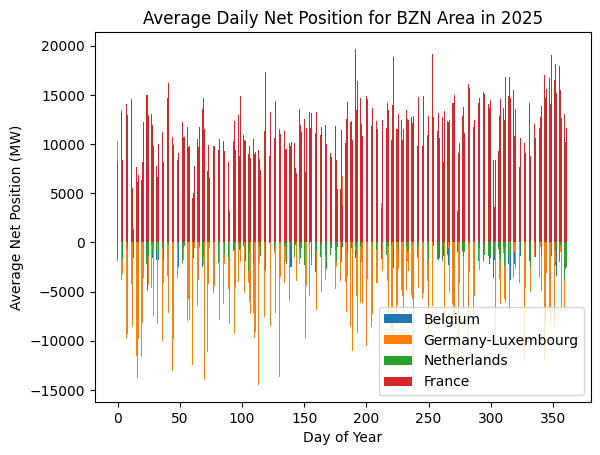

In [63]:
df['day'] = df['Time'].dt.dayofyear
print(df.head())

plt.bar(range(0,363),df[df['Area'] == 'BZN|BE'].groupby('day')['Net position'].mean(), width=0.5)
plt.bar(range(0,363),df[df['Area'] == 'BZN|DE-LU'].groupby('day')['Net position'].mean(), width=0.5)
plt.bar(range(0,363),df[df['Area'] == 'BZN|NL'].groupby('day')['Net position'].mean(), width=0.5)
plt.bar(range(0,363),df[df['Area'] == 'BZN|FR'].groupby('day')['Net position'].mean(), width=0.5)
plt.xlabel('Day of Year')
plt.ylabel('Average Net Position (MW)')
plt.title('Average Daily Net Position for BZN Area in 2025')
plt.legend(['Belgium', 'Germany-Luxembourg', 'Netherlands', 'France'])
plt.show()

                 Time Line   Flow_MW   RAM  utilization  congested  hour
0 2025-01-01 00:00:00   L1  -190.016  1000     0.190016      False     0
1 2025-01-01 00:00:00   L2  2801.766   800     3.502207       True     0
2 2025-01-01 00:00:00   L3  -839.435   600     1.399058       True     0
3 2025-01-01 00:00:00   L4 -1772.315   400     4.430787       True     0
4 2025-01-01 00:15:00   L1 -1182.076  1000     1.182076       True     0
hour        0         1         2         3         4         5         6   \
Line                                                                         
L1    0.979986  0.979282  0.981354  0.991022  0.993094  0.988950  0.988950   
L2    0.964113  0.959945  0.967541  0.966160  0.970304  0.971685  0.986188   
L3    0.988958  0.989641  0.994475  0.996547  0.997238  0.984116  0.952348   
L4    0.881988  0.888122  0.890193  0.880525  0.881215  0.915746  0.940608   

hour        7         8         9   ...        14        15        16  \
Line                

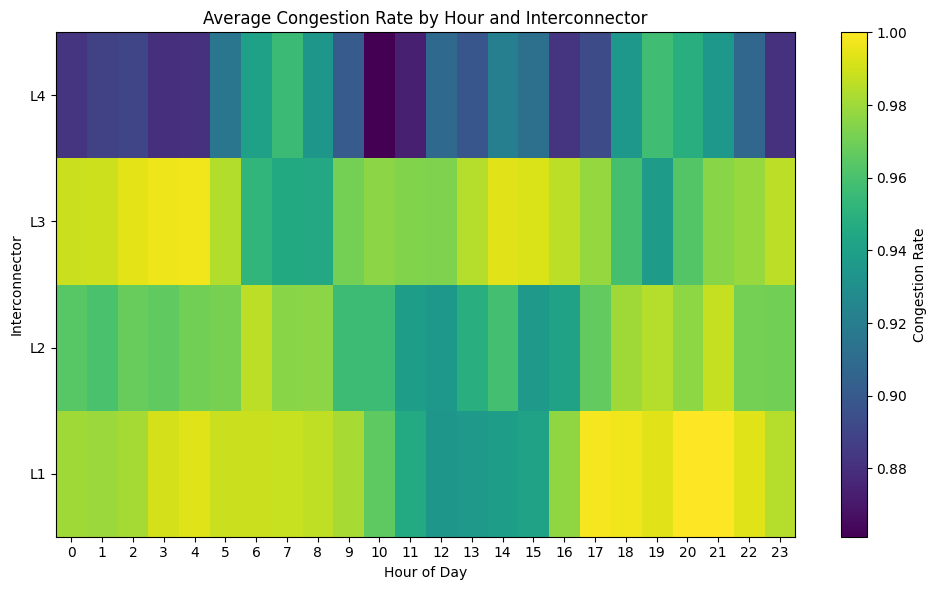

In [76]:
df_flow['hour'] = df_flow['Time'].dt.hour
print(df_flow.head())

# --- Heat Map Plot ---
fig, ax = plt.subplots(figsize=(10, 6))
pivot_table = df_flow.pivot_table(index="Line", columns="hour", values="congested", aggfunc="mean")
print(pivot_table)
cax = ax.imshow(pivot_table, aspect='auto', cmap='viridis', origin='lower')
ax.set_title("Average Congestion Rate by Hour and Interconnector")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Interconnector")
ax.set_xticks(range(0, 24))
ax.set_yticks(range(len(pivot_table.index)))
ax.set_yticklabels(pivot_table.index)
fig.colorbar(cax, ax=ax, label="Congestion Rate")
plt.tight_layout()
plt.show()


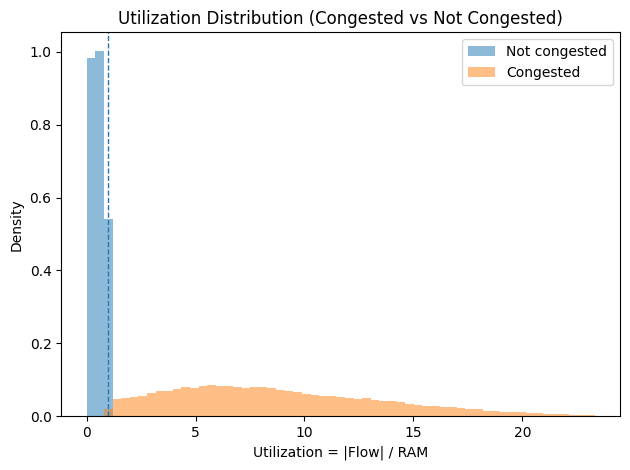

In [ ]:
df_flow = df_flow.copy()
df_flow["congested"] = df_flow["congested"].astype(bool)
df_flow["utilization"] = pd.to_numeric(df_flow["utilization"], errors="coerce")
df_flow = df_flow.dropna(subset=["utilization", "congested"])

# --- Plot: utilization distributions, split by congested flag ---
util_cong = df_flow.loc[df_flow["congested"], "utilization"].to_numpy()
util_free = df_flow.loc[~df_flow["congested"], "utilization"].to_numpy()

# Choose bins robustly (ignore extreme outliers for bin range)
hi = np.nanpercentile(df_flow["utilization"], 99.5)
hi = max(hi, 1.5)  # keep some headroom even if data is tight
bins = np.linspace(0, hi, 60)

fig, ax = plt.subplots()

ax.hist(util_free, bins=bins, density=True, alpha=0.5, label="Not congested")
ax.hist(util_cong, bins=bins, density=True, alpha=0.5, label="Congested")

ax.axvline(1.0, linestyle="--", linewidth=1)  # utilization = 1 threshold
ax.set_title("Utilization Distribution (Congested vs Not Congested)")
ax.set_xlabel("Utilization = |Flow| / RAM")
ax.set_ylabel("Density")
ax.legend()

plt.tight_layout()
plt.show()

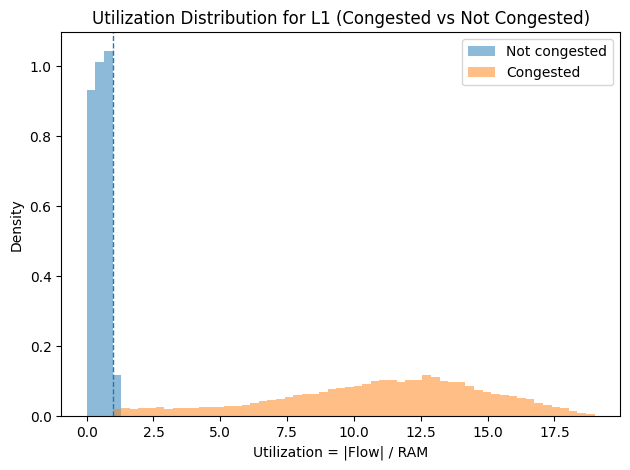

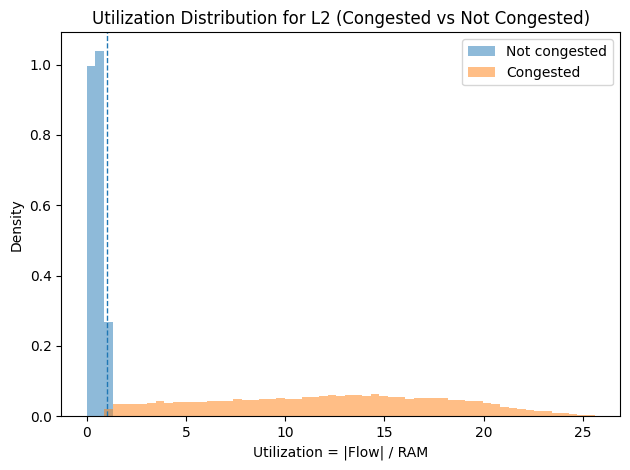

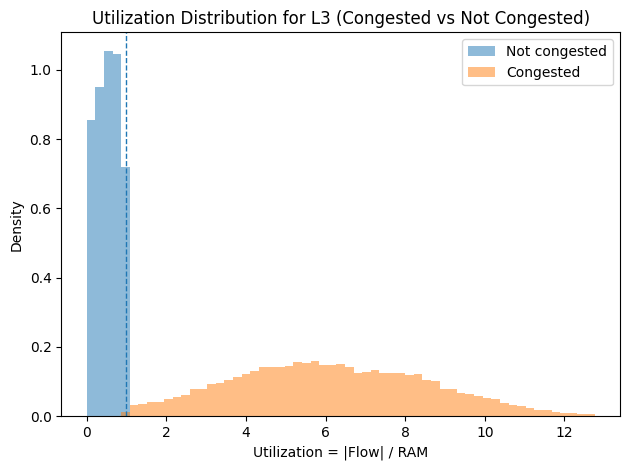

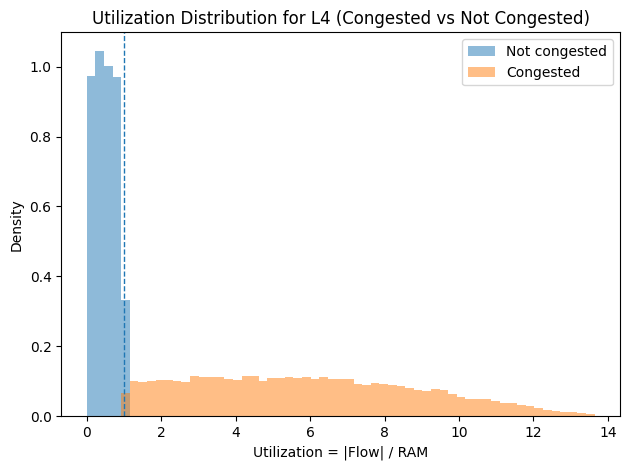

In [ ]:
df_flow = df_flow.copy()

for l in df_flow['Line'].unique():
    df_line = df_flow[df_flow['Line'] == l]
    util_cong = df_line.loc[df_line["congested"], "utilization"].to_numpy()
    util_free = df_line.loc[~df_line["congested"], "utilization"].to_numpy()

    # Choose bins robustly (ignore extreme outliers for bin range)
    hi = np.nanpercentile(df_line["utilization"], 99.5)
    hi = max(hi, 1.5)  # keep some headroom even if data is tight
    bins = np.linspace(0, hi, 60)

    fig, ax = plt.subplots()

    ax.hist(util_free, bins=bins, density=True, alpha=0.5, label="Not congested")
    ax.hist(util_cong, bins=bins, density=True, alpha=0.5, label="Congested")

    ax.axvline(1.0, linestyle="--", linewidth=1)  # utilization = 1 threshold
    ax.set_title(f"Utilization Distribution for {l} (Congested vs Not Congested)")
    ax.set_xlabel("Utilization = |Flow| / RAM")
    ax.set_ylabel("Density")
    ax.legend()

    plt.tight_layout()
    plt.show()

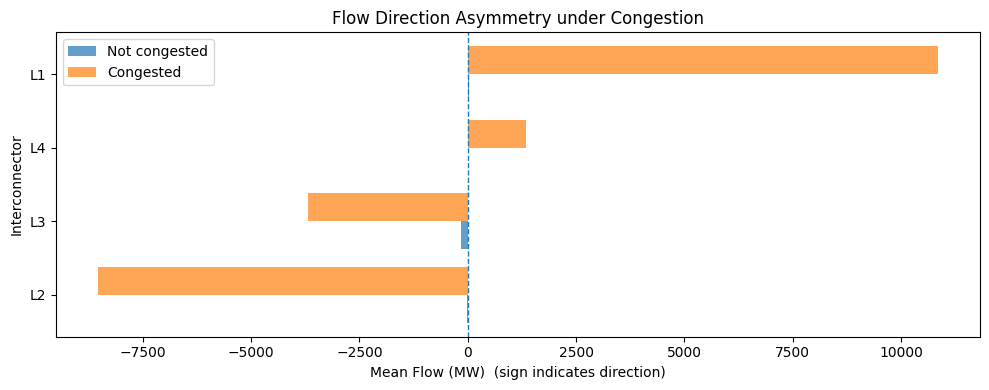

In [ ]:
def flow_direction_asymmetry(df: pd.DataFrame) -> pd.DataFrame:
    """Compute mean flow (MW) by Line for congested vs not congested, plus differences."""
    x = df.copy()
    x["congested"] = x["congested"].astype(bool)
    x["Flow_MW"] = pd.to_numeric(x["Flow_MW"], errors="coerce")
    x = x.dropna(subset=["Line", "Flow_MW", "congested"])

    summary = (
        x.groupby(["Line", "congested"])["Flow_MW"]
         .mean()
         .unstack("congested")
         .rename(columns={False: "mean_flow_not_congested", True: "mean_flow_congested"})
    )

    # Ensure both columns exist even if one regime is missing for a line
    for col in ["mean_flow_not_congested", "mean_flow_congested"]:
        if col not in summary.columns:
            summary[col] = np.nan

    summary["delta_flow_cong_minus_free"] = (
        summary["mean_flow_congested"] - summary["mean_flow_not_congested"]
    )

    # Optional: absolute magnitude change
    summary["delta_abs_flow_cong_minus_free"] = (
        summary["mean_flow_congested"].abs() - summary["mean_flow_not_congested"].abs()
    )

    return summary.reset_index()


def plot_flow_direction_asymmetry(summary: pd.DataFrame, sort_by: str = "delta_flow_cong_minus_free"):
    """Horizontal bar plot with two bars per line, plus a zero reference."""
    s = summary.copy()
    if sort_by in s.columns:
        s = s.sort_values(sort_by)

    lines = s["Line"].to_numpy()
    y = np.arange(len(lines))
    h = 0.38

    fig, ax = plt.subplots(figsize=(10, max(4, 0.45 * len(lines))))

    ax.barh(y - h/2, s["mean_flow_not_congested"], height=h, alpha=0.7, label="Not congested")
    ax.barh(y + h/2, s["mean_flow_congested"], height=h, alpha=0.7, label="Congested")

    ax.axvline(0, linestyle="--", linewidth=1)
    ax.set_yticks(y)
    ax.set_yticklabels(lines)

    ax.set_title("Flow Direction Asymmetry under Congestion")
    ax.set_xlabel("Mean Flow (MW)  (sign indicates direction)")
    ax.set_ylabel("Interconnector")
    ax.legend()

    plt.tight_layout()
    plt.show()


# --- Run ---
summary = flow_direction_asymmetry(df_flow)
plot_flow_direction_asymmetry(summary)